In [1]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os
import gym
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
env = gym.make("MountainCar-v0")

In [2]:
import gym
import time
import optuna
import numpy as np
from blueqat import opt
Opt = opt.Opt

In [3]:
from random import random

# なんか色々定義

In [4]:
env = gym.make("MountainCar-v0")
qstr = "{}*(1 - (q0 + q1 + q2))^2"

In [5]:
def get_matrix(position, velocity, a=5, b=1e-2):
    # 中心を0に近づけ、負の値を正にする
    e_p = abs(position + 0.5)
    e_p = 0

    matrix = [-1*(e_p+a*abs(velocity + b * -1)), -1*(e_p+a *
                                                     abs(velocity + b * 0)), -1*(e_p+a*abs(velocity + b * 1))]
    return matrix

In [6]:
qaoa_action_dic = {(1, 0, 0): 0, (0, 1, 0): 1,
                   (0, 0, 1): 2, (1, 0): 0, (0, 1): 2}


def get_action(action_qaoa):
    return qaoa_action_dic[action_qaoa]


def get_qaoa(p, v, a, b, c):
    return Opt().add(np.diag(get_matrix(p, v, a, b))).add(qstr.format(c))


def get_max_position(obs):
    return max([(i[0] + 0.5)**2 for i in obs])

# optunaしてみる

In [7]:
# 50回回して評価
n_actions = 50


def objective(trial):
    # v の位がpとおなじか多いぐらいの範囲に補正
    a = trial.suggest_loguniform("a", 10, 1000)
    # push がvとおなじぐらいの範囲に補正
    b = trial.suggest_loguniform("b", 0.01, 1)
    # v に負けない程度
    c = trial.suggest_loguniform("c", 10, 100)
    
    observation = env.reset()
    missed_count = 0
    obs = []

    for i in range(n_actions):
        p, v = observation

        problem = get_qaoa(p, v, a, b, c)

        action_qaoa = tuple(problem.run())
        #action_qaoa = problem.qaoa().most_common()[0][0]
        while sum(action_qaoa) != 1:
            missed_count += 1
            if missed_count == n_actions:
                return 100
            action_qaoa = tuple(problem.run())

        action = get_action(action_qaoa)

        observation, reward, done, info = env.step(action)

        obs.append(observation)
        
        if observation[0] >= 0.50:
            return -(n_actions + 1 - len(obs)) * 100
        
        if done == True:
            break


    return -100 * get_max_position(obs)
    #return 100  -get_max_position(obs) *100
    #return 100

In [8]:
start = time.time()
study = optuna.create_study()
study.optimize(objective, n_trials=50, n_jobs=-1)
seconds = time.time() - start

[I 2019-05-31 17:29:22,535] Finished trial#3 resulted in value: -12.154121129594987. Current best value is -12.154121129594987 with parameters: {'a': 11.056788131048894, 'b': 0.7988600860405396, 'c': 10.176475571143198}.
[I 2019-05-31 17:29:43,415] Finished trial#4 resulted in value: -24.213991864613394. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}.
[I 2019-05-31 17:29:56,133] Finished trial#11 resulted in value: -24.163306975239387. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}.
[I 2019-05-31 17:29:58,786] Finished trial#5 resulted in value: -14.389378615745557. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}.
[I 2019-05-31 17:29:58,896] Finished trial#7 resulted in value: -16.118623425092796. Current best value is -24.2139

[I 2019-05-31 17:32:53,182] Finished trial#38 resulted in value: 100.0. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}.
[I 2019-05-31 17:32:53,881] Finished trial#39 resulted in value: 100.0. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}.
[I 2019-05-31 17:32:56,271] Finished trial#40 resulted in value: 100.0. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}.
[I 2019-05-31 17:32:56,592] Finished trial#41 resulted in value: 100.0. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}.
[I 2019-05-31 17:32:56,821] Finished trial#43 resulted in value: 100.0. Current best value is -24.213991864613394 with parameters: {'a': 94.49888888714469, 'b': 0.19470

In [9]:
seconds

240.47586226463318

In [10]:
study.best_params.values()

dict_values([94.49888888714469, 0.19470344974338694, 22.809078334550176])

In [11]:
study.best_params

{'a': 94.49888888714469, 'b': 0.19470344974338694, 'c': 22.809078334550176}

In [12]:
a, b, c = study.best_params.values()

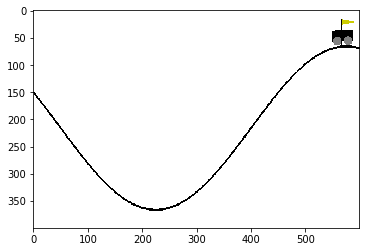

In [13]:
observation = env.reset()

fig = plt.figure()
ims = []
actions = []
missed_count = 0
obs = []

for i in range(200):
    p, v = observation

    problem = get_qaoa(p, v, a, b, c)

    action_qaoa = tuple(problem.run())
    # problem.qaoa().most_common()[0][0]
    while sum(action_qaoa) != 1:
        missed_count += 1
        action_qaoa = tuple(problem.run())
        if missed_count >=  400:
            print("どうやらだめそうなようです。")
            raise(Exception)

    action = get_action(action_qaoa)

    actions.append(action)

    observation, reward, done, info = env.step(action)
    obs.append(observation)

    im = plt.imshow(env.render(mode='rgb_array'))
    ims.append([im])

    if done == True:
        break

In [14]:
problem.qubo

array([[-39.97146808,  45.61815667,  45.61815667],
       [  0.        , -24.04594825,  45.61815667],
       [  0.        ,   0.        , -42.44520792]])

In [15]:
problem.run()

[0, 0, 1]

In [16]:
len(obs)

105

In [17]:
missed_count

0

In [18]:
ani = animation.ArtistAnimation(fig, ims, interval=15, blit=True)
rc('animation', html='jshtml')
ani

In [23]:
len(actions)

105

In [21]:
actions

[2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]